#Molecular Simulation Using **Robosample**

In this lab we will simulate SARS-COV-2 Mpro protease with Robosample using its Python interface. Then, we will run a short rigid body dynamics HMC simulation.

# Theoretical Aspects - Markov Chains

In [ ]:
# Install PyGraphviz
!if pip list | grep pygraphviz ; then echo "PyGraphviz" is installed; else apt install libgraphviz-dev && pip install pygraphviz; fi


Q =  [[0.   1.   0.   0.  ]
 [0.   0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]]


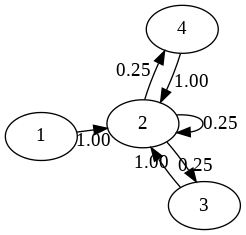

In [15]:
import pygraphviz as pgv
from IPython.display import Image
import numpy as np

# Define a graph
myGraph={'1': {'2': None}, '2': {'2': None, '3': None, '4': None}, '3': {'2': None}, '4': {'2': None}}
A=pgv.AGraph(myGraph, directed=True)
#A.to_string()

# Build a transition probability matrix
Q = np.zeros((A.number_of_nodes(), A.number_of_nodes()))
for edge in (A.iteredges()):
  nodes = [int(edge[0]), int(edge[1])]
  w = 1.0 / len(np.unique(A.neighbors(nodes[0])))
  Q[nodes[0] - 1, nodes[1] - 1] = w
  edge = A.get_edge(str(nodes[0]), str(nodes[1]))
  edge.attr['weight'] = w
  edge.attr['label'] = '%.2f' % w

print("Q = ", Q)

# Draw graph
A.layout()
A.draw('file.png')
Image('file.png')

**EXERCISE**: please correct the chain above to be well behaved.

In [16]:
# Simple simulation
pi = np.array([0.1, 0.1, 0.1, 0.7])
for i in range(10):
  pi = np.dot(pi, Q)
  print(pi)


[0.    0.925 0.025 0.025]
[0.      0.28125 0.23125 0.23125]
[0.        0.5328125 0.0703125 0.0703125]
[0.         0.27382813 0.13320313 0.13320313]
[0.         0.33486328 0.06845703 0.06845703]
[0.         0.22062988 0.08371582 0.08371582]
[0.         0.22258911 0.05515747 0.05515747]
[0.         0.16596222 0.05564728 0.05564728]
[0.         0.15278511 0.04149055 0.04149055]
[0.         0.12117739 0.03819628 0.03819628]


# Theoretical Aspects - Simulations with Constraints 

Molecules conformations lie in complex highly dimensional spaces, and present a challange for molecular simulations that try to explore them. Take, for example, ethane: although it is a simple molecule, it already has $8 \times 3 = 24$ dimensions. To simplify this endevour some types of degrees of freedom may be constrained: such as bond lengths. This will increase the integration time step and reduce the number equations solved at each step.





<figure>
<center>
<img src='https://github.com/spirilaurentiu/Notebooks/blob/main/ethane.s.png?raw=true' />
<figcaption>FIGURE 1. Ethane Molecule </figcaption>
</center>
</figure>

## Internal Coordinates
Internal coordinates, also called BAT, are the set of bond lengths, bond angles and bond torsions of a molecular system.


* As opposed to Cartesian coordinates which are absolute, BAT coordinates are relative.
* Allows the external degrees of freedom to be ignored because they are explicitly expressed in BAT
* BAT coordinates have energy terms associated with them which makes trajectories easier to calculate
* Energies associated with the three types of coordinates differ in their order of magnitude which gives them the advantage to easly constrain them by type: eg. one can fix all the bond lengths during molecular dynamics.


BAT | Cartesian
--------------------------------|-----
relative                        | absolute
have corresponding energy terms | don't -//-







## Rigid Body Dynamics 

In the case of biological macromolecules, their particular chemistry may induce certain patterns that can be speculated for the use of constraints. For example, proteins have secondary structures elements such as helices, that can be treated as rigid bodies during some parts of the simulation.

If we apply these type of constraints some molecule parts become rigid and **robot mechanics** algorithms can be employed to solve the equations of motion.
The mechanical part of a robot is defined as a system of articulated bodies, which is a set of bodies (links) connected by articulations (joints).

Constraints can be enforced using:
* maximal coordinates for the links (in which every link is represented with its 6 degrees of freedom) and additional equations for each constraint applyed to the whole system;
* reduced coordinates for articulations degrees of freedom

Robosample uses the complement of the set of constraints: which is the set of the remaining degrees of freedom. These remaining degrees of freedom set is called a "World".




<figure>
<center>
<img src='https://github.com/spirilaurentiu/Notebooks/blob/main/protein.s.png?raw=true' />
<figcaption>FIGURE 2. Proteins secondary structures </figcaption>
</center>
</figure>

Using constraints, by definition, do not take into account all the degrees of freedom therefore suffers from a lack of ergodicity. Also, particular degrees of freedom may be coupled when transitioning from a conformational basin to another. We overcome this in Robosample through the means of "overlaped blocked Gibbs sampling" described below.

Gibbs sampling is a Markov Chain Monte Carlo algorithm which samples from a multivariate distribution $\pi(X = \{x_i\})$ by taking turns in sampling each of its component $x_i$, conditioned on the previous sampled components $\pi(x_i | \{x_{0,i-1}\})$.

In a similar fashion, the algorithm allows sampling jointly multiple components $x_{i, i+k}$ in what is called "blocked Gibbs sampling". Even more so, the components may overlap to form "overlapped blocked Gibbs sampling".

We will use this particular type of Gibbs sampling in Robosample by alternating multiple definitions of rigid bodies.
 Robosample is a molecular simulation program that uses algorithms designed primarly for robot mechanics. 




**QUESTIONS**

* Why shoud we consider using constraints?
* What macromolecule regions would you pick to constraint during different simulations?


### Further Reading
A comprehensive desciption internal coordinates molecular dynamics and usage of constraints is given in [J Phys Chem B. 2015, **119(4)**, 1233-42](https://pubs.acs.org/doi/10.1021/jp509136y).

The way they are implemented in Robosample is found in:  [ J Chem Theory Comput. 2017, **13(10)**, 4649-4659](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5634954/) and [Biochim Biophys Acta Gen Subj. 2020, **1864(8)** 129616](https://pubmed.ncbi.nlm.nih.gov/32298789/).


# Part 0 - Download and Install Robosample

---



Robosample binaries are already build on Google colab and uploaded on Github. Clone the Github repository that contains Robosample binaries.

In [ ]:
%cd /content/
! if [ -d Notebooks ]; then echo "Notebooks exists"; else git clone --recursive https://github.com/spirilaurentiu/Notebooks.git; fi
!ls Notebooks
%cd Notebooks/
!git pull

/content
Notebooks exists
ala10	      mproc	     robosample.ipynb		       temp
build	      mproc.png      robosample.ipynb:Zone.Identifier  test.ipynb
ethane.s.png  protein.s.png  robots			       tools
inp.test      README.md      simulate.py
/content/Notebooks
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 9 (delta 5), reused 9 (delta 5), pack-reused 0
Unpacking objects: 100% (9/9), done.
From https://github.com/spirilaurentiu/Notebooks
   3021a5a..dc28bb8  main       -> origin/main
Updating 3021a5a..dc28bb8
Fast-forward
 build/release/robosample/src/GMOLMODEL_robo        | Bin 818520 -> 817960 bytes
 .../release/robosample/src/libGMOLMODEL_dynamic.so | Bin 830648 -> 830632 bytes
 .../src/libOpenMMPlugin.so:Zone.Identifier         |   0
 build/release/robosample/src/libSimTKmolmodel.so   | Bin 1776616 -> 1776568 bytes
 4 files changed, 0 insertions(+), 0 deletions(-)
 mode change 100755 

 Now we have to make sure that Robosample binary finds its libraries. Set the linker path.
 Robosample relies heavly on GPUs. Set cuda directories.

In [ ]:
%env LD_LIBRARY_PATH=/usr/lib64-nvidia:/usr/local/openmm/lib:/usr/local/openmm/lib/plugins:/content/Notebooks/build/release/robosample/src
#%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64-nvidia:/content/Notebooks/build/release/robosample/src
!echo "$LD_LIBRARY_PATH"

%env CUDA_INC_DIR=/usr/local/cuda
%env CUDA_ROOT=/usr/local/cuda


%cd /content/Notebooks/build/release/robosample/src/
%mkdir -p /usr/local/openmm/lib/plugins
%cp libOpenMMOpenCL.so libOpenMMRPMDCUDA.so libOpenMMRPMDOpenCL.so libOpenMMCUDA.so libOpenMMCudaCompiler.so libOpenMMCPU.so /usr/local/openmm/lib/plugins/
%cp libOpenMM.so libOpenMM.so.7.5 libOpenMMRPMD.so /usr/local/openmm/lib/

!nvidia-smi

env: LD_LIBRARY_PATH=/usr/lib64-nvidia:/usr/local/openmm/lib:/usr/local/openmm/lib/plugins:/content/Notebooks/build/release/robosample/src
/usr/lib64-nvidia:/usr/local/openmm/lib:/usr/local/openmm/lib/plugins:/content/Notebooks/build/release/robosample/src
env: CUDA_INC_DIR=/usr/local/cuda
env: CUDA_ROOT=/usr/local/cuda
/content/Notebooks/build/release/robosample/src
Mon Mar 14 14:17:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000

If everything went okay so far, Robosample should run on a test small molecule.

In [ ]:
%cd build/release/robosample/src/
!./GMOLMODEL_robo inp.2but

/content/Notebooks/build/release/robosample/src
Reading input...
Dumping input file:
  BOOST_MDSTEPS : 1 
  BOOST_TEMPERATURE : 600 
  DIHEDRAL : 0 1 2 3 
  DISTANCE : 0 1 
  FFSCALE : AMBER 
  FIXMAN_POTENTIAL : TRUE 
  FIXMAN_TORQUE : TRUE 
  FLEXFILE : ligand.td.flex 
  GBSA : 1.0 
  GEOMETRY : FALSE 
  INPCRD : ligand.inpcrd 
  MDSTEPS : 10 
  MOLECULES : 2but 
  NMA_OPTION : 0 
  NONBONDED_CUTOFF : 2 
  NONBONDED_METHOD : 0 
  OPENMM : TRUE 
  OPENMM_CalcOnlyNonbonded : TRUE 
  OUTPUT_DIR : temp 
  PRINT_FREQ : 1 
  PRMTOP : ligand.prmtop 
  RANDOM_WORLD_ORDER : FALSE 
  RBFILE : ligand.rb 
  REPRODUCIBLE : FALSE 
  ROOTS : 0 
  ROOT_MOBILITY : Free 
  ROUNDS : 10 
  ROUNDS_TILL_REBLOCK : 10 
  RUN_TYPE : Normal 
  SAMPLER : VV 
  SAMPLES_PER_ROUND : 1 
  SEED : 42 
  TEMPERATURE_FIN : 300 
  TEMPERATURE_INI : 300 
  THERMOSTAT : Andersen 
  THREADS : 0 
  TIMESTEPS : 0.003 
  VISUAL : FALSE 
  WORLDS : R1 
  WRITEPDBS : 0 
Done.
Molecule directory: 2but
tcmalloc: large alloc 1073

Now we need to install Robosample python interface

In [ ]:
# MDTraj is a prerequisite for robosample.py
!if pip list | grep mdtraj ; then echo "MDTraj is installed"; else pip install mdtraj; fi
!if pip list | grep pytraj ; then echo "PyTraj is installed"; else pip install pytraj; fi
!if pip list | grep nglview ; then echo "NglView is installed"; else pip install -q nglview; fi
!if pip list | grep py3Dmol ; then echo "Py3DMol is installed"; else pip install py3Dmol; fi

# Robosample Python interface is in the tools directory
%env PYTHONPATH=/env/python:/content/Notebooks/tools
!echo $PYTHONPATH


     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mdtraj: filename=mdtraj-1.9.7-cp37-cp37m-linux_x86_64.whl size=5533585 sha256=c62b266c25afc440abe3ca9bfee4b39c5e00909cef0eb92ae3fd18dc78663dfe
  Stored in directory: /root/.cache/pip/wheels/6f/84/9d/6854e5264a4423209de26a6e4b34d13750289c72ba0439bbfd
Successfully built mdtraj
     |████████████████████████████████| 16.1 MB 4.8 MB/s 
     |████████████████████████████████| 5.7 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
env: PYTHONPATH=/env/python:/content/Notebooks/tools
/env/python:/content/Notebooks/tools


If everything went OK we should be able to set up a simple example with the Python interface.

In [ ]:

%cd /content/Notebooks/
!cp -i build/release/robosample/src/libOpenMMPlugin.so .
!ls

/content/Notebooks
cp: overwrite './libOpenMMPlugin.so'? n
ala10	      libOpenMMPlugin.so  README.md			    simulate.py
build	      mproc		  robosample.ipynb		    temp
ethane.s.png  mproc.png		  robosample.ipynb:Zone.Identifier  test.ipynb
inp.test      protein.s.png	  robots			    tools


In [ ]:
# Run a test script
! if [ -d temp ]; then echo "temp directory exists"; else mkdir -p temp/pdbs; fi
!ls
!python simulate.py

temp directory exists
ala10	      libOpenMMPlugin.so  README.md			    simulate.py
build	      mproc		  robosample.ipynb		    temp
ethane.s.png  mproc.png		  robosample.ipynb:Zone.Identifier  test.ipynb
inp.test      protein.s.png	  robots			    tools
GPU
Starting Simulation init
Robosample directory set to /content/Notebooks
Robosample executable set to /content/Notebooks/build/release/robosample/src/GMOLMODEL_robo
DEBUG ['bot.prmtop']
Done Simulation init
robots/bot0/bot.rst7 ['robots/bot0/bot.prmtop']
Calculating distance matrix...
Calculating dssp...
coils [[ 1 11]]
flatClusts [3 2 3 2 5 4 5 4 1 1 1 1 4 5 4 5 2 3 2 3]
8 [48, 54, 'CA', 5, 'C', 5, array([ 1.4058620e-01, -1.5154932e+00, -9.9000000e-06])] [48, 54, 'CA', 5, 'C', 5, array([ 1.4058620e-01, -1.5154932e+00, -9.9000000e-06])]
9 [46, 48, 'N', 5, 'CA', 5, array([-1.2978867e+00, -6.4427650e-01,  4.6000000e-06])] [46, 48, 'N', 5, 'CA', 5, array([-1.2978867e+00, -6.4427650e-01,  4.6000000e-06])]
10 [58, 64, 'CA', 6, 'C', 6, array(

In [ ]:
!ls temp/pdbs

final.bot01.0000000005.pdb    sb.bot01.0.s0.0000000003.pdb
sb.bot01.0.s0.0000000000.pdb


# Part 1 - Prepare a Robosample Script

---

<h1>Why use a script?<!h1>

Molecular dynamics simulations require a lot of information about
* Input data
  * coordinates
  * topology
  * which atoms are included in energy terms
  * parameters for functions in energy terms
* System description
  * periodicity
  * constraints
* Integrators
  * algorithms to propagate forward in time
  * adjust box size
  * adjust kinetic energy (temperature)
* Simulation
  * how long to run
  * how much output data to store

  Let's go through what the parameters mean and I'll give you values for a simple simulation of MPro C-terminal part.



<img src='https://github.com/spirilaurentiu/Notebooks/blob/main/mproc.png?raw=true' />

In [ ]:
# Get molecule
!ls mproc/

2liz.pdb  ligand.min.rst7  ligand.prmtop


<h1>Import necessary modules</h1>
First we need to import the module that contains the Robosample interface, robosample.py. Also import here oher modules that we may need.

In [ ]:
import sys
sys.path.append("/content/Notebooks/tools/")
import os

import nglview as nv
from google.colab import output
output.enable_custom_widget_manager()




In [ ]:
#!touch /content/__init__.py
#!touch /content/Notebooks/__init__.py
#!touch /content/Notebooks/tools/__init__.py

# Imports
from robosample import *


<h1>Load molecular structure files</h1>

* For input files enter “mproc/ligand.prmtop” and “mproc/ligand.min.rst7”
“Platform” describes the version of the code and the hardware it will run on
  * “CUDA” and “OpenCL” are meant for GPUs, which make MD simulations much faster. “CUDA” only works with Nvidia GPUs and “OpenCL” on others
  * “CPU” is a faster version of Reference.

* The properties dictionary indicates the number of threads to be used
* “Forcefield” is the set of parameters and functions that describes the energy of a system. Currently, Robosample only supports Amber functional form.



In [ ]:
# Load Amber files
prmtop = AmberPrmtopFile("mproc/ligand.prmtop")
inpcrd = AmberInpcrdFile("mproc/ligand.min.rst7")

# Hardware platform
platform = Platform.getPlatformByName('GPU')
properties={'nofThreads': 0}


GPU


<h1>Create System </h1>

* “Nonbonded method” describes how long-range interactions are treated. The more interactions that need to be computed, the slower an MD simulation will be. 
  * Cutoffs don’t perform calculations if two particles are beyond a certain distance apart.
  * Ewald methods calculate long-range interaction energies between a system and its periodic images. It assumes the system repeats indefinitely.
  * Since we are using implicit solvent, we don’t need periodicity. 
Let’s use “CutoffNonPeriodic”.
* “Constraints”
  * force a degree of freedom to be a certain value

Let’s keep the other “System” parameters as is

In [ ]:
# Remove any existing robots directory
if os.path.exists("robots"):
  shutil.rmtree("robots")

# Create a Robosample system by calling createSystem on prmtop
system = prmtop.createSystem(createDirs = True,
	nonbondedMethod = "CutoffPeriodic",
 	nonbondedCutoff = 1.44*nanometer,
 	constraints = None,
 	rigidWater = True,
 	implicitSolvent = True,
 	soluteDielectric = 1.0,
 	solventDielectric = 78.5,
 	removeCMMotion = False
)


<h1> Choose an Integrator </h1>

* “Integrator” is the algorithm that goes from one configuration to the next
  * Verlet is completely deterministic
  * Langevin adds some random noise to the motion. The level of noise maintains the system at a certain temperature.
  * Brownian is so random that there is no momentum
  * Variable methods use different time steps and depend on an error tolerance
  * Robosample Hybrid Monte Carlo uses Velocity Verlet

<h1> Thermostats </h1>

* allows the kinetic energy of the system to change by modifying velocities
  * Andersen
  * Berendsen
  * Nose Hoover

Robosample uses Andersen

  <h1> Barostats</h1>

* keep the system at a certain pressure 
  * allows the volume of the system to change
    * Hoover
    * Rahman
    * Parrinello

since we are using implicit water, we will not use a barostat.

In [ ]:
# Choose an integrator
integrator = VVIntegrator(300*kelvin,   # Temperature of head bath
                           0.001*picoseconds) # Time step

<h1>Wrap everything in a Simulation Object</h1>

* “Reporters” store data about the simulation

  * “PDB” structure files are saved in the specified output directory
  * “DCD” is a binary file format for molecular dynamics trajectories

* “Report Interval” is how often the data are stored


In [ ]:
# Create Simulation object
simulation = Simulation(prmtop.topology, system, integrator, platform, properties)
simulation.reporters.append(PDBReporter('temp', 3))
simulation.context.setPositions(inpcrd.positions)

Starting Simulation init
Robosample directory set to /content/Notebooks
Robosample executable set to /content/Notebooks/build/release/robosample/src/GMOLMODEL_robo
DEBUG ['bot.prmtop']
Done Simulation init
robots/bot0/bot.rst7 ['robots/bot0/bot.prmtop']
Calculating distance matrix...
Calculating dssp...
coils [[  0  13]
 [ 28  40]
 [ 50  57]
 [ 71  74]
 [ 88 108]
 [111 120]]
flatClusts [1 7 4 ... 7 7 7]
0 [4, 12, 'CA', 0, 'C', 0, array([ 1.0200005,  0.1549997, -1.150999 ])] [4, 12, 'CA', 0, 'C', 0, array([ 1.0200005,  0.1549997, -1.150999 ])]
5 [38, 40, 'N', 2, 'CA', 2, array([-0.4510002, -0.7189998, -1.2069988])] [38, 40, 'N', 2, 'CA', 2, array([-0.4510002, -0.7189998, -1.2069988])]
6 [57, 67, 'CA', 3, 'C', 3, array([1.336    , 0.7650003, 0.0860004])] [57, 67, 'CA', 3, 'C', 3, array([1.336    , 0.7650003, 0.0860004])]
11 [79, 81, 'N', 5, 'CA', 5, array([ 0.681    ,  0.2849999, -1.2810002])] [79, 81, 'N', 5, 'CA', 5, array([ 0.681    ,  0.2849999, -1.2810002])]
14 [108, 114, 'CA', 7, '



<h1> Add Worlds </h1>

The concept of "World" is esential to Robosample.

When simulating the molecular system with constraints, Robosample uses the complement of the set of constraints: which is the set of the remaining degrees of freedom. These remaining degrees of freedom set is called a "World", and corresponds to a Gibbs block.




<h3>Types of Worlds:</h3>

*accesibile* : computed based on the solvent accesible surface are (SASA) will give mostly the exposed rotamers - known to give most of, for example, receptor flexibility in ligand binding

*loops*: regions between secondary structures <br />

*stretch*: only a particular stretch of amino acids <br />

*roll*: builds a World for every backbone torsion angle within a stretch <br />


In [ ]:
## Generate NMA-Scaled Flex Files
sAll = [[1, 120]]
nterJoint = [[11, 12]]

simulation.addWorld(regionType='stretch',
                    region=sAll,
                    rootMobility='Weld',
                    timestep=0.003,
                    mdsteps=40,
                    argJointType='Pin',
                    subsets=['rama','side'],
                    samples=1)

simulation.addWorld(regionType='stretch',
                    region=nterJoint,
                    rootMobility='Weld',
                    timestep=0.02,
                    mdsteps=5,
                    argJointType='Pin',
                    subsets=['rama','side'],
                    samples=1)


Starting Simulation addWorld
region [[  1 120]]
flatRegion [  1   2   3 ... 118 119 120]
Wrote to bot.stretch.2.flex
Done Simulation addWorld
Starting Simulation addWorld
region [[11 12]]
flatRegion [11 12]
Wrote to bot.stretch.3.flex
Done Simulation addWorld


<h1>Run the simulation </h1>

The Simulation step function in Robosample takes the number of **rounds** as input (not the number of steps of MD).


In [ ]:

# Run simulation
simulation.step(300)



Starting Simulation step
Done Simulation step


In [ ]:
!rm temp/pdbs/*
!ls robots/bot0/
!cat inp.test
!./build/release/robosample/src/GMOLMODEL_robo inp.test

Streaming output truncated to the last 5000 lines.
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsToMobods Warning: Trying to scale a bond inside a rigid body
World::setUScaleFactorsTo

In [ ]:
!ls temp/pdbs/* | wc -l

27


**QUESTION** 

In [ ]:
import pytraj as pt
traj = pt.load('temp/pdbs/*.pdb', 'mproc/ligand.prmtop')
pt.write_traj('temp.dcd', traj, overwrite=True)
!ls -lht

total 1.5M
-rw-r--r-- 1 root root 587K Mar 14 15:33 temp.dcd
-rw-r--r-- 1 root root  986 Mar 14 15:32 inp.test
drwxr-xr-x 4 root root 4.0K Mar 14 15:29 robots
drwxr-xr-x 3 root root 4.0K Mar 14 14:21 temp
drwxr-xr-x 4 root root 4.0K Mar 14 14:21 tools
-rw-r--r-- 1 root root  47K Mar 14 14:21 libOpenMMPlugin.so
-rw-r--r-- 1 root root 1.4K Mar 14 14:13 simulate.py
-rw-r--r-- 1 root root  730 Mar 14 14:13 test.ipynb
-rw-r--r-- 1 root root 431K Mar 14 14:13 robosample.ipynb
-rw-r--r-- 1 root root    0 Mar 14 14:13 robosample.ipynb:Zone.Identifier
-rwxr-xr-x 1 root root 157K Mar 14 14:13 protein.s.png
drwxr-xr-x 2 root root 4.0K Mar 14 14:13 mproc
-rwxr-xr-x 1 root root 171K Mar 14 14:13 mproc.png
-rwxr-xr-x 1 root root  41K Mar 14 14:13 ethane.s.png
drwxr-xr-x 2 root root 4.0K Mar 14 14:13 ala10
drwxr-xr-x 3 root root 4.0K Mar 14 14:13 build
-rw-r--r-- 1 root root   30 Mar 14 14:13 README.md


In [ ]:
# Visualize

traj = pt.load('temp.dcd', 'mproc/ligand.prmtop')
traj.superpose(ref=0, mask='@CA')
view = nv.show_pytraj (traj)
#view.add_line(traj)
view.zoomTo()
view.show()


NameError: ignored